# Lab 7.8.1: Explain The Attributes—Slump Dataset


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import silhouette_score, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
df = pd.read_csv('Lab 7.8.1 concrete_slump_test.csv')
print(df.columns)
display(df.head(2))

Index(['No', 'Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'Compressive Strength (28-day)(Mpa)'],
      dtype='object')


,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14


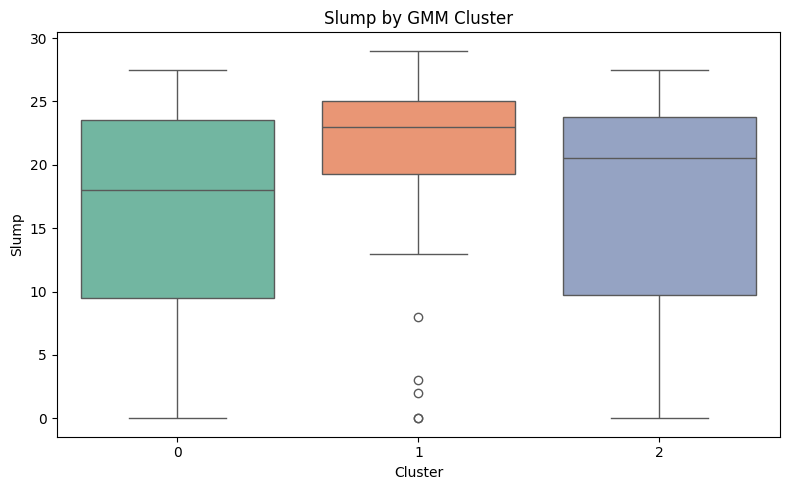

Cluster
0    15.320000
1    20.540000
2    16.035714
Name: Slump, dtype: float64


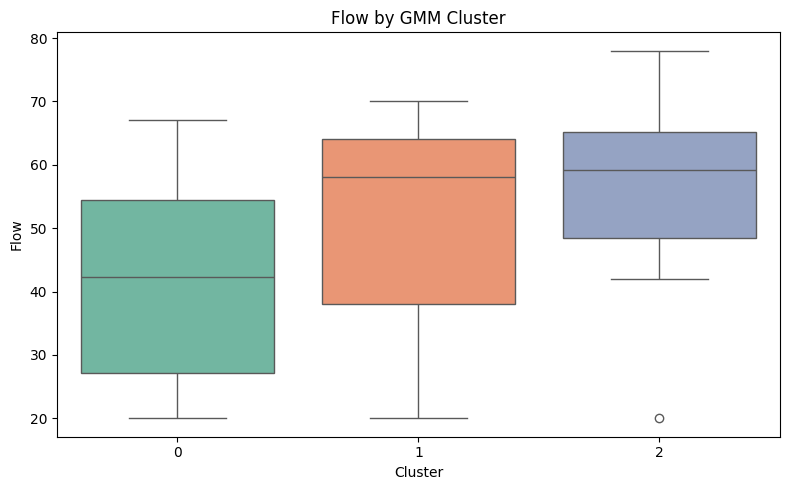

Cluster
0    41.346154
1    49.933962
2    57.850000
Name: Flow, dtype: float64


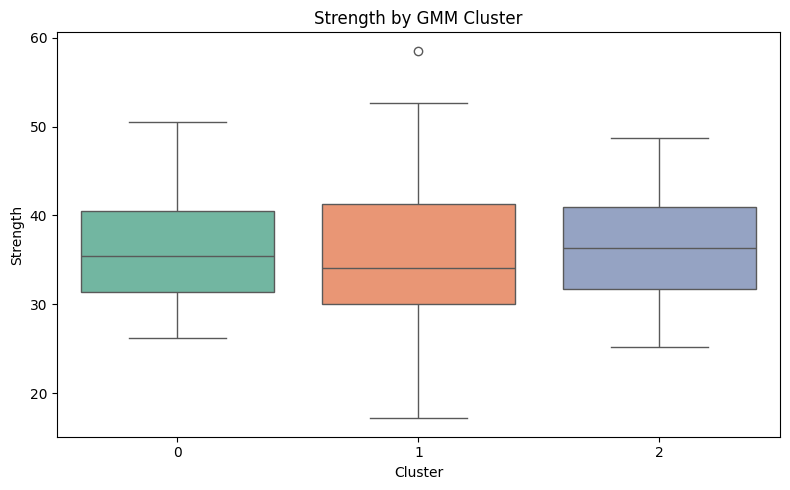

Cluster
0    36.639615
1    35.512326
2    36.247059
Name: Strength, dtype: float64


In [5]:
df.columns = ['No', 'Cement', 'Slag', 'FlyAsh', 'Water', 'SP', 'CoarseAggr', 'FineAggr', 'Slump', 'Flow', 'Strength']

# Helper function to apply GMM and plot result
def apply_em_and_plot(target_column):
    features = df.drop(columns=[target_column])
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # Apply Gaussian Mixture Model
    gmm = GaussianMixture(n_components=3, random_state=42)
    cluster_labels = gmm.fit_predict(X_scaled)

    # Add cluster labels to original DataFrame for analysis
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = cluster_labels

    # Plot target variable by cluster
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_with_clusters, x='Cluster', y=target_column, hue='Cluster', palette='Set2', legend=False)
    plt.title(f'{target_column} by GMM Cluster')
    plt.ylabel(target_column)
    plt.xlabel('Cluster')
    plt.tight_layout()
    plt.show()

    # Print average target value per cluster
    cluster_means = df_with_clusters.groupby('Cluster')[target_column].mean()
    print(cluster_means)

# Run analysis for each target
apply_em_and_plot('Slump')
apply_em_and_plot('Flow')
apply_em_and_plot('Strength')



=== EM Analysis for 'Slump' ===


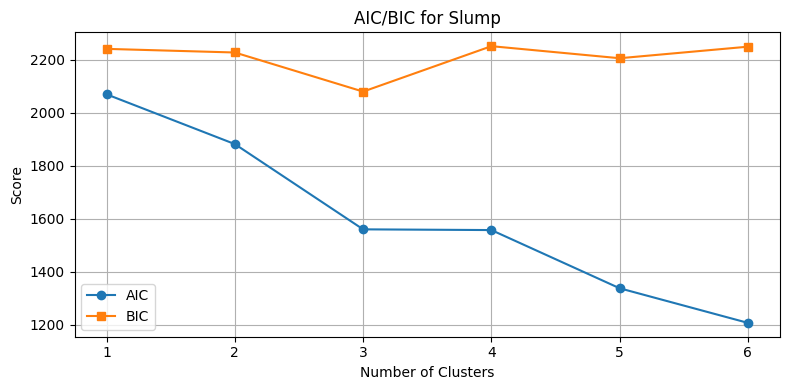

Best model for 'Slump' → 3 clusters (BIC=2079.18)


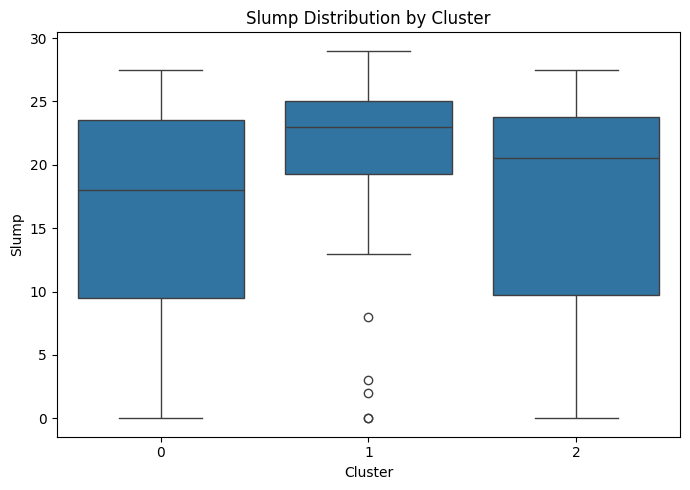


Mean target value per cluster:
Cluster
0    15.32
1    20.54
2    16.04
Name: Slump, dtype: float64

=== EM Analysis for 'Flow' ===


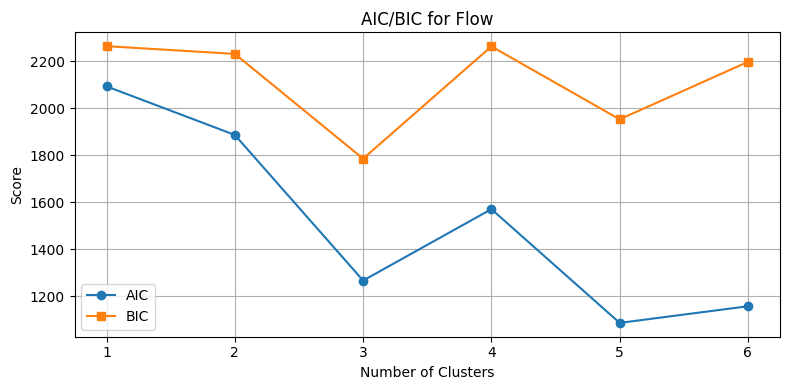

Best model for 'Flow' → 3 clusters (BIC=1786.14)


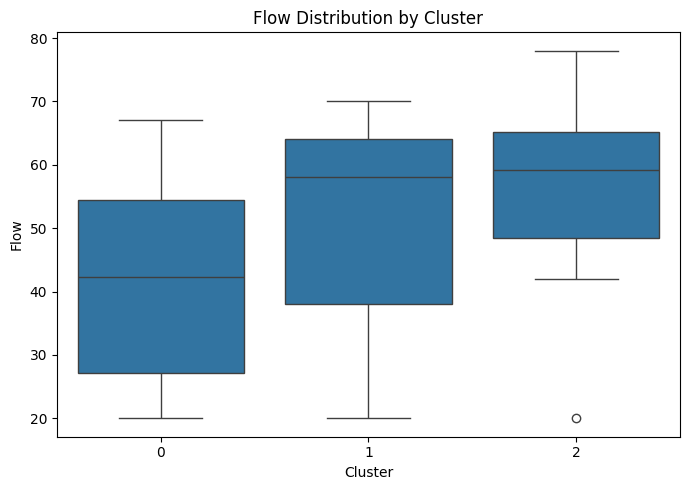


Mean target value per cluster:
Cluster
0    41.35
1    49.93
2    57.85
Name: Flow, dtype: float64

=== EM Analysis for 'Strength' ===


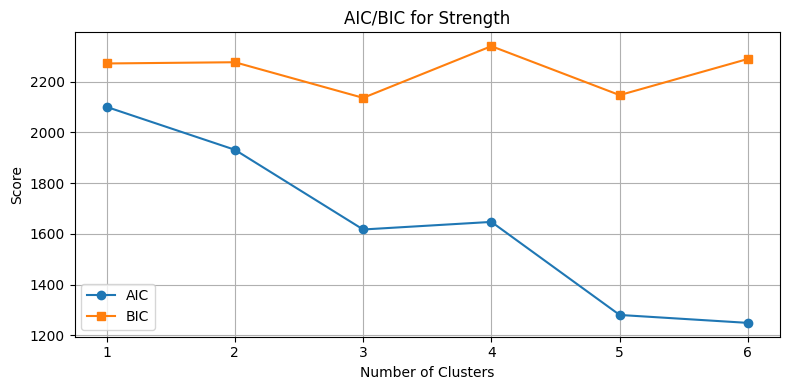

Best model for 'Strength' → 3 clusters (BIC=2136.44)


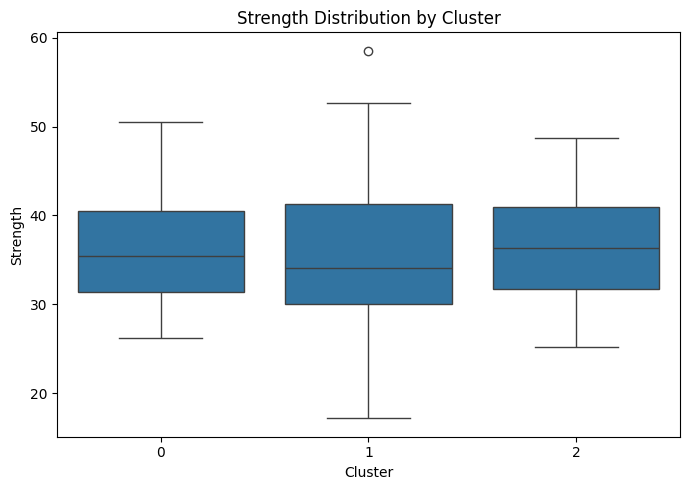


Mean target value per cluster:
Cluster
0    36.64
1    35.51
2    36.25
Name: Strength, dtype: float64
Slump BIC 2079.178487857918
Flow BIC 1786.136725277205
Strength BIC 2136.43745584593


In [6]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Rename columns for ease
df.columns = ['No', 'Cement', 'Slag', 'FlyAsh', 'Water', 'SP', 'CoarseAggr', 'FineAggr', 'Slump', 'Flow', 'Strength']

def evaluate_gmm_models(X, max_clusters=6):
    aics, bics = [], []
    models = []

    for k in range(1, max_clusters + 1):
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        models.append(gmm)

    return aics, bics, models

def apply_em_with_model_selection(df, target_column, max_clusters=6):
    print(f"\n=== EM Analysis for '{target_column}' ===")

    features = df.drop(columns=[target_column])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    aics, bics, models = evaluate_gmm_models(X_scaled, max_clusters)

    # Plot AIC and BIC
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_clusters + 1), aics, label='AIC', marker='o')
    plt.plot(range(1, max_clusters + 1), bics, label='BIC', marker='s')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'AIC/BIC for {target_column}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Select best model (based on BIC)
    best_n = np.argmin(bics) + 1
    best_gmm = models[best_n - 1]
    best_bic = bics[best_n - 1]
    print(f"Best model for '{target_column}' → {best_n} clusters (BIC={best_bic:.2f})")

    # Assign clusters and plot outcome
    labels = best_gmm.predict(X_scaled)
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels

    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df_with_clusters, x='Cluster', y=target_column)
    plt.title(f'{target_column} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.tight_layout()
    plt.show()

    print("\nMean target value per cluster:")
    print(df_with_clusters.groupby('Cluster')[target_column].mean().round(2))
    return X_scaled, best_bic

res = {}
for t in ['Slump', 'Flow', 'Strength']:
    X_scaled, best_bic = apply_em_with_model_selection(df, t)
    res[t] = X_scaled, best_bic
for t in ['Slump', 'Flow', 'Strength']:
    print(f'{t} BIC', res[t][1])

In [7]:
print(f"KMeans Clustering to predict Concerete attributes")
n_clusters = 3
for t in ['Slump', 'Flow', 'Strength']:
    kmeans = KMeans(n_clusters=n_clusters)
    y_means = kmeans.fit_predict(res[t][0])
    inertia = float(kmeans.inertia_)
    print(f"{t} Inertia (SSE) for KMeans: {inertia}")
    silhouette_score_value = silhouette_score(X_scaled, y_means)
    print(f"{t} Silhouette Score for KMeans: {silhouette_score_value}")

KMeans Clustering to predict Concerete attributes
Slump Inertia (SSE) for KMeans: 699.4621172254183
Slump Silhouette Score for KMeans: 0.1558922329277102
Flow Inertia (SSE) for KMeans: 706.4926444999336
Flow Silhouette Score for KMeans: 0.15902251600782266
Strength Inertia (SSE) for KMeans: 695.6890790587273
Strength Silhouette Score for KMeans: 0.1725555349518267


In [14]:
print(f"KMeans Clustering to predict Concrete attributes")
n_clusters = 3
for t in ['Slump', 'Flow', 'Strength']:
    # Prepare data
    X_scaled = res[t][0]  # Assuming res[t][0] is the scaled feature matrix
    y_true = bin_continuous_target(df[t])  # Bin the continuous target into 3 classes

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_pred = kmeans.fit_predict(X_scaled)

    # Metrics
    inertia = float(kmeans.inertia_)
    silhouette = silhouette_score(X_scaled, y_pred)
    acc = cluster_accuracy(y_true, y_pred)

    # Output
    print(f"\n{t} Inertia (SSE) for KMeans: {inertia:.2f}")
    print(f"{t} Silhouette Score for KMeans: {silhouette:.3f}")
    print(f"{t} Clustering Accuracy (vs binned true labels): {acc:.3f}")

KMeans Clustering to predict Concrete attributes

Slump Inertia (SSE) for KMeans: 700.02
Slump Silhouette Score for KMeans: 0.215
Slump Clustering Accuracy (vs binned true labels): 0.408

Flow Inertia (SSE) for KMeans: 706.41
Flow Silhouette Score for KMeans: 0.184
Flow Clustering Accuracy (vs binned true labels): 0.427

Strength Inertia (SSE) for KMeans: 674.59
Strength Silhouette Score for KMeans: 0.219
Strength Clustering Accuracy (vs binned true labels): 0.369


In [9]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

def bin_continuous_target(y, n_bins=3):
    return pd.qcut(y, q=n_bins, labels=False)

def cluster_accuracy(y_true, y_pred):
    # Match cluster labels to true labels using Hungarian Algorithm
    D = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-D)
    accuracy = D[row_ind, col_ind].sum() / y_true.size
    return accuracy

def compare_clustering_accuracy(X_scaled, y_true, best_gmm, best_k=3):
    # GMM predictions
    em_labels = best_gmm.predict(X_scaled)
    em_acc = cluster_accuracy(y_true, em_labels)
    
    # KMeans predictions
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    kmeans_acc = cluster_accuracy(y_true, kmeans_labels)
    
    print(f"\n=== Classification Accuracy ===")
    print(f"EM (GMM):    {em_acc:.3f}")
    print(f"KMeans:      {kmeans_acc:.3f}")


--- Slump ---

=== EM Analysis for 'Slump' ===


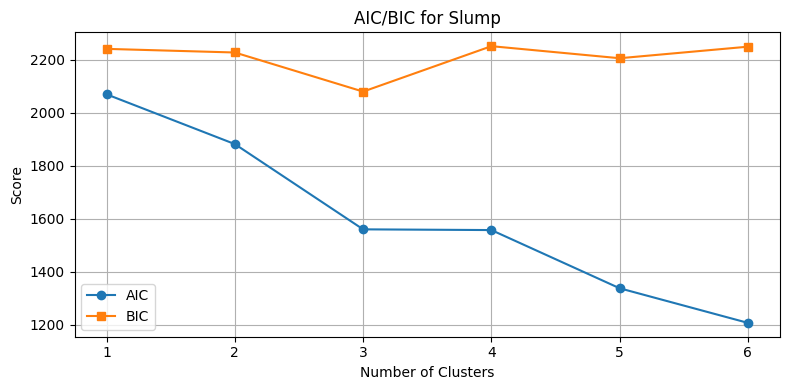

Best model for 'Slump' → 3 clusters (BIC=2079.18)


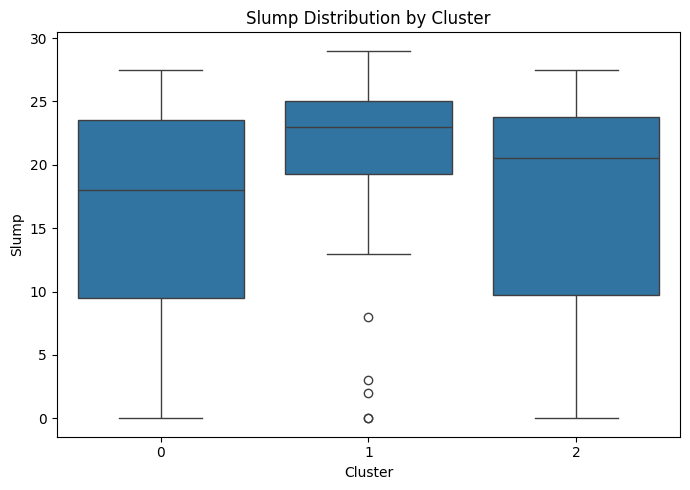


Mean target value per cluster:
Cluster
0    15.32
1    20.54
2    16.04
Name: Slump, dtype: float64

=== Classification Accuracy ===
EM (GMM):    0.398
KMeans:      0.408

--- Flow ---

=== EM Analysis for 'Flow' ===


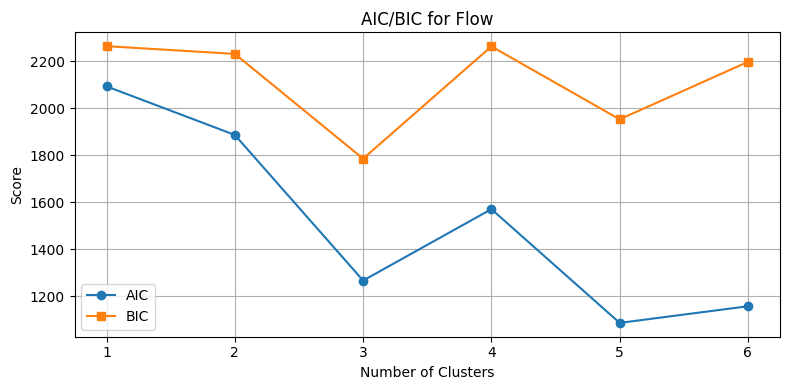

Best model for 'Flow' → 3 clusters (BIC=1786.14)


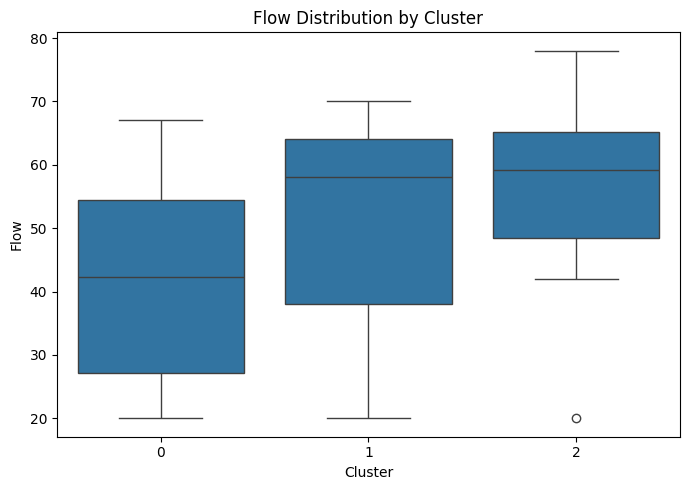


Mean target value per cluster:
Cluster
0    41.35
1    49.93
2    57.85
Name: Flow, dtype: float64

=== Classification Accuracy ===
EM (GMM):    0.456
KMeans:      0.427

--- Strength ---

=== EM Analysis for 'Strength' ===


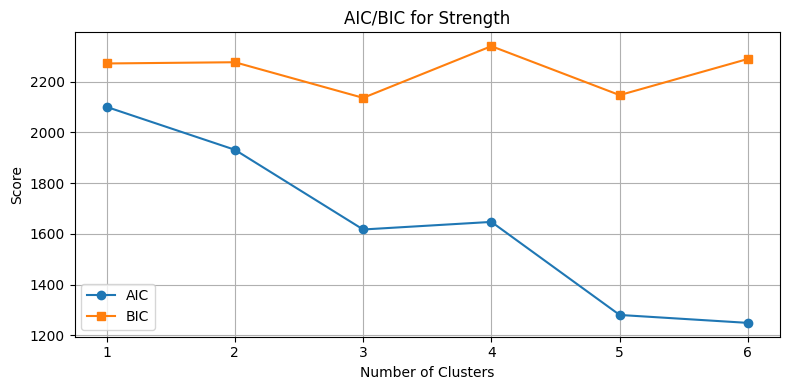

Best model for 'Strength' → 3 clusters (BIC=2136.44)


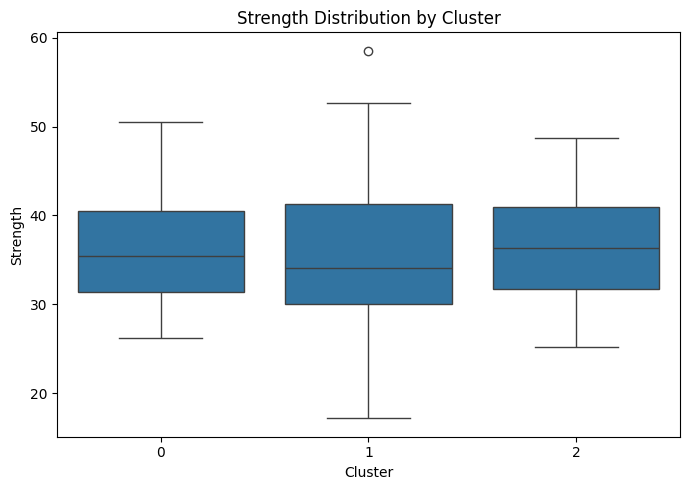


Mean target value per cluster:
Cluster
0    36.64
1    35.51
2    36.25
Name: Strength, dtype: float64

=== Classification Accuracy ===
EM (GMM):    0.388
KMeans:      0.369


In [13]:
n_clusters = 3
for t in ['Slump', 'Flow', 'Strength']:
    print(f"\n--- {t} ---")
    # Run EM
    X_scaled, bic = apply_em_with_model_selection(df, t)
    # Bin the continuous target into classes
    y_true = bin_continuous_target(df[t])
    # Fit best GMM again
    best_gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(X_scaled)
    compare_clustering_accuracy(X_scaled, y_true.to_numpy(), best_gmm, best_k=n_clusters)